<a href="https://colab.research.google.com/github/jacksonshaiz/lab_scraping/blob/main/lab1_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Web Scraping

Lots of great data is available online, but available through inconveniently formatted web pages. When this is the case, sometimes you can simply copy and paste the data into a .csv file and go on with your life. But if there are many records to parse and combine into a dataset, that might be impossible. Can we automate the collection of data from online sources?

This is called web scraping. Broadly speaking: Web scraping is legal, but what you plan to do with the results of your scraping might not be. In general, most sites do not want you to scrape them at this point, but there is not really a way to stop you if you are sufficiently motivated. Be careful to use server resources respectfully (not too many requests per unit time), think seriously about privacy concerns, and be careful who you share your work with and how it is used.

We'll be scraping data about used cars in Charlottesville from Craigslist, particularly this page: https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0

We'll use the `requests` package to get web pages off the Internet and into Python. Again, we'll use a header with a user-agent that masks our true identity so that we're not rejected by the server. This particular url points to the car listings for Craigslist in Charlottesville. To use requests, you pass a `url` for the page you want and a `header` that controls how you appear to the server to `requests.get`:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'} # How we wish to appear to CL
url = 'https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0' # The page we want to scrape
raw = requests.get(url,headers=header) # Get page

Now that we have that particular page available locally, we want to **parse** it and get results from it. To do that, we can use a package called `beautifulSoup` or `bs4`.

What does `beautifulSoup` do for us? Let's go to the web page of interest. You probably see something like this:

![Listings](./src/craigslist.png "Craigslist")

But if you "view page source" -- which is CTRL+U -- in Chrome, you see what the computer sees:

![Listings](./src/craigslist_source.png "Craigslist")

Since your web browser needs lots of instructions about how to render the text, pictures, and other content on your web page, there are a lot of clues about where the data live and how to extricate them from a page. These clues are called **tags**. If you wander the source for the search page on cars, you see a particular `class = "cl-static-search-result"` term appear attached to each listing:

![Listings](./src/listing.png "Craigslist")

This structure can be exploited to search the page for information. This kind of detective work -- looking at the page source, finding the interesting tags, and then searching the page with `beautifulSoup` -- is the basic job of web scraping.

What I do is look at the rendered page, find the text I want and copy it, then search for that text in the HTML code that the computer sees. When I find the text I want, I look for the tag nearby. Here, it's `cl-static-search-result`: That's what I'll want beautifulSoup to search for.

The following code chunk takes the raw content from `requests` and turns it into a beautifulSoup object, which can search the page and return results for us:

In [ ]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings of the kind we want

Why is the argument `class_` and not just `class`? The word `class` is a reserved keyword for Python, and cannot be used by anyone else, similar to `True` and `False`. But since we want the `class = "cl-static-search-result"` terms, we need to use the `class_` argument to the `.find_all` method.

The `.find_all` function dredges the entire page and finds all the instances of `class = "cl-static-search-result"`, resulting in a list of entries. We can then parse the entries.

Parsing the entries can be a challenge! We have to go back to what a listing looks like, and look at the tags within the listing. They're typically `div` tags with a `class` like price or location. You then have to experiment a bit with `.find` and the HTML to make sure you're getting the information you want. For each listing, the `.find` method to search within the listing record for specific information, but it's typically still wrapped in the tag. To get the real information we want, we can then use `.get_text()`. I end up using a code chunk to experiment and play with a record to make sure I'm getting as close to what I want as possible.

In the code below, two more things happen. You don't need to do them in your work, but they're helpful to know about.

First, I would like to get the brand of the car from the post title, if possible. To do this, I split the title into words using `title.split()`, and then I use a list comprehension to look over every word in the title and check whether it appears in the `brands` list.

Second, I would like to get the year the car was built, if possible, so I can determine the vehicle's age. To do this, I use a thing called **regular expressions** that provides a language for expressing patterns. Do I remember how to do this off the top of my head? No, I read a few pages in a book and looked on StackOverflow for answers. Roughly, in order to express the idea "any year starting with 20xx," you can write `20[0-9][0-9]`, and for "any year starting with 19xx," you can write `19[0-9][0-9]`. The `[0-9]`'s act as wildcards for any digit. This allows me to use the `re` package to find any instances of year-like numbers in the title text, using `re.search(r'20[0-9][0-9]|19[0-9][0-9]', title )`.

This is all nested in a for-loop over the listings, and the data is appended to a list.

In [ ]:
import re # Regular expressions

brands = ['honda', 'dodge','toyota','ford','tesla','gmc','jeep','bmw','mitsubishi','mazda',
          'volvo','audi','volkswagen','chevy','chevrolet','acura','kia','subaru','lexus',
          'cadillac','buick','porsche','infiniti']

data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # Get brand from the title string:
    words = title.split()
    hits = [word for word in words if word in brands] # Find brands in the title
    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]
    # Get years from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title ) # Find year references
    if regex_search is None: # If no hits, record year as missing value
        year = np.nan
    else: # If hits, record year as first match
        year = regex_search.group(0)
    #
    data.append({'title':title,'price':price,'year':year,'link':link,'brand':brand})


With the data scraped from Craigslist, we can put it in a dataframe and wrangle it. Of course, price and year come in as text, not numbers, and need to be typecast/coerced:

In [ ]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
df['age'] = 2025-df['year']
print(df.shape)
df.to_csv('./src/craigslist_cville_cars.csv') # Save data in case of a disaster
df.head()

(69, 6)


OSError: Cannot save file into a non-existent directory: 'src'

With the data in and wrangled, we can now do some analysis:

count       69.000000
mean     10810.115942
std      12536.780823
min       1000.000000
25%       3500.000000
50%       7000.000000
75%      12500.000000
max      79999.000000
Name: price, dtype: float64


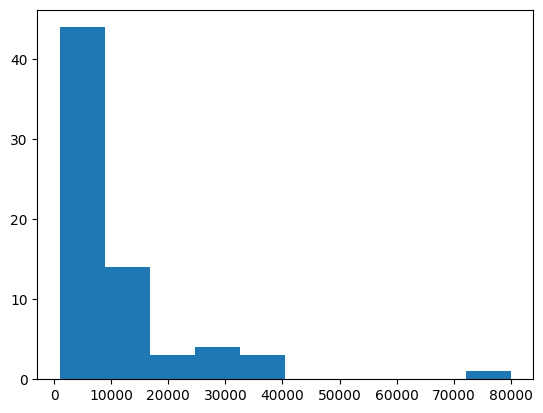

count    61.000000
mean     17.295082
std      12.740152
min       3.000000
25%      11.000000
50%      15.000000
75%      19.000000
max      70.000000
Name: age, dtype: float64


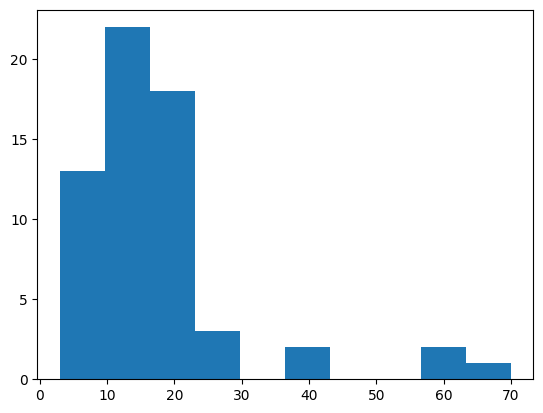

In [ ]:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()
print(df['age'].describe())
df['age'].hist(grid=False)
plt.show()

In [ ]:
# Price by brand:
df.loc[:,['price','brand']].groupby('brand').describe()

price                                                          \
           count          mean           std      min       25%      50%   
brand                                                                      
acura        1.0   3500.000000           NaN   3500.0   3500.00   3500.0   
audi         1.0   9500.000000           NaN   9500.0   9500.00   9500.0   
bmw          3.0  13743.333333   3029.460898  10500.0  12365.00  14230.0   
chevrolet    2.0  13500.000000  14142.135624   3500.0   8500.00  13500.0   
chevy        4.0  14749.750000   9350.106965   2999.0  10124.75  15500.0   
dodge        2.0  27000.000000  18384.776311  14000.0  20500.00  27000.0   
ford         6.0  12082.500000  12527.603023   1000.0   2100.00   7647.5   
honda        6.0   4391.666667   2017.031647   1000.0   3750.00   4700.0   
jeep         5.0   8990.000000   5182.952826   3250.0   5700.00   7500.0   
lexus        1.0   5000.000000           NaN   5000.0   5000.00   5000.0   
mazda        1.0   1000.000000           NaN   1000.0   1000.00   1000.0   
missing     23.0  11601.695652  17561.745273   1000.0   2800.00   5000.0   
porsche      1.0  23900.000000           NaN  23900.0  23900.00  23900.0   
subaru       3.0   5583.333333   3125.833222   2000.0   4500.00   7000.0   
toyota       8.0  10325.000000  10305.996867   3500.0   5900.00   7450.0   
volkswagen   1.0   7500.000000           NaN   7500.0   7500.00   7500.0   
volvo        1.0   4285.000000           NaN   4285.0   4285.00   4285.0   

                               
                 75%      max  
brand                          
acura        3500.00   3500.0  
audi         9500.00   9500.0  
bmw         15365.00  16500.0  
chevrolet   18500.00  23500.0  
chevy       20125.00  25000.0  
dodge       33500.00  40000.0  
ford        21373.75  30000.0  
honda        5350.00   6950.0  
jeep        12500.00  16000.0  
lexus        5000.00   5000.0  
mazda        1000.00   1000.0  
missing     10000.00  79999.0  
porsche     23900.00  23900.0  
subaru       7375.00   7750.0  
toyota       8225.00  35500.0  
volkswagen   7500.00   7500.0  
volvo        4285.00   4285.0

In [ ]:
# Age by brand:
df.loc[:,['age','brand']].groupby('brand').describe()

age                                                      
           count       mean        std   min    25%   50%    75%   max
brand                                                                 
acura        1.0  18.000000        NaN  18.0  18.00  18.0  18.00  18.0
audi         1.0  11.000000        NaN  11.0  11.00  11.0  11.00  11.0
bmw          3.0  13.000000   6.928203   9.0   9.00   9.0  15.00  21.0
chevrolet    1.0  70.000000        NaN  70.0  70.00  70.0  70.00  70.0
chevy        4.0  18.000000  14.899664   6.0   8.25  13.5  23.25  39.0
dodge        2.0  10.000000   1.414214   9.0   9.50  10.0  10.50  11.0
ford         6.0  13.000000   8.763561   4.0   5.00  12.5  20.75  23.0
honda        6.0  17.000000   4.242641  12.0  13.50  17.0  20.50  22.0
jeep         5.0  22.600000  11.436783  11.0  17.00  19.0  25.00  41.0
lexus        1.0  17.000000        NaN  17.0  17.00  17.0  17.00  17.0
mazda        1.0  14.000000        NaN  14.0  14.00  14.0  14.00  14.0
missing     17.0  17.941176  16.199809   5.0  10.00  13.0  17.00  62.0
porsche      1.0  12.000000        NaN  12.0  12.00  12.0  12.00  12.0
subaru       3.0  16.666667   8.962886  11.0  11.50  12.0  19.50  27.0
toyota       7.0  14.000000   6.557439   3.0  12.00  15.0  15.50  25.0
volkswagen   1.0  17.000000        NaN  17.0  17.00  17.0  17.00  17.0
volvo        1.0  19.000000        NaN  19.0  19.00  19.0  19.00  19.0

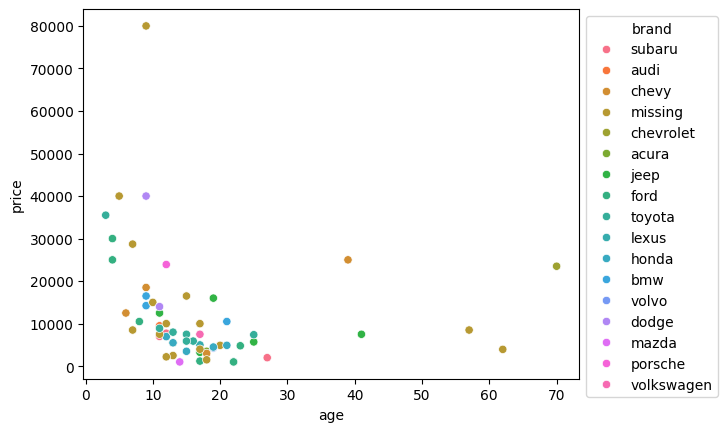

In [ ]:
ax = sns.scatterplot(data=df, x='age', y='price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

           log_price   log_age
log_price   0.942494 -0.248920
log_age    -0.248920  0.367372
           log_price   log_age
log_price   1.000000 -0.426553
log_age    -0.426553  1.000000


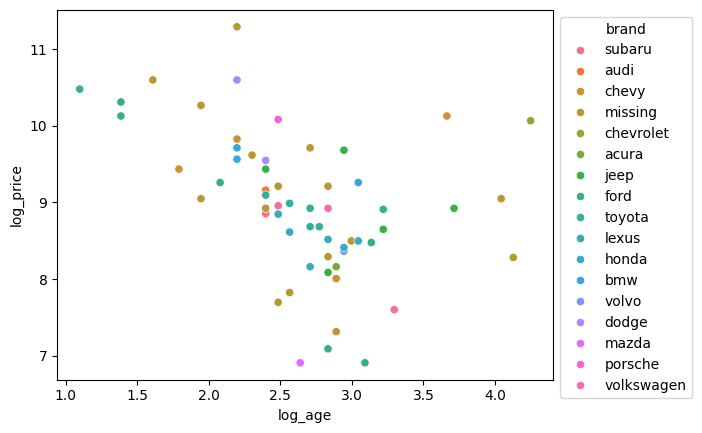

In [ ]:
df['log_price'] = np.log(df['price'])
df['log_age'] = np.log(df['age'])

ax = sns.scatterplot(data=df, x='log_age', y='log_price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

print(df.loc[:,['log_price','log_age']].cov())
print(df.loc[:,['log_price','log_age']].corr())

## The Lab:


1. Pick something else on Craigslist besides used cars: Musical instruments, roommates, antiques, etc. Look at the search page and its source code. Record which fields/data you would like to gather, and what kinds of basic EDA you'd do with it.
2. Get your search results of interest using `requests` and extract data from them using `beautifulSoup`, using code similar to what's above.
3. Wrangle your data into a dataframe and do some basic descriptions and plots. Try to find some interesting relationships or stories to tell about your data.
4. Document all your work as code and markdown blocks in this notebook.

We want to look at furniture on Craigslist. The link we are scraping along with our desired fields are listed below.

Furniture: https://charlottesville.craigslist.org/search/fua#search=2~gallery~0

- Type of Furniture (Chair, table, lamp, couch, dresser, desk, art, bed, drawers, rug, cabinet)
- Price
- Location (Charlottesville, Downtown Charlottesville, Afton, Louisa, Crozet, Gordonsville, Troutville)

Once we have the data, we want to see if there are any trends in prices across both furniture types and location. This might help buyers guide decisions about where/what to purchase for cheap.

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'} # How we wish to appear to CL
url = 'https://charlottesville.craigslist.org/search/fua#search=2~gallery~0' # The page we want to scrape
raw = requests.get(url,headers=header) # Get page

In [ ]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings of the kind we want

In [ ]:
import re
furniture_types = ['chair','table','lamp','couch',
             'dresser','desk','art','bed','drawers', 'rug', 'cabinet']

In [ ]:
# Cleans location names to return only places in this group (ex. Afton instead of Afton, VA)
locations = ["Charlottesville","Downtown Charlottesville","Afton","Louisa","Crozet","Gordonsville","Troutville"]
def normalize_location(txt):
    if not txt: return "Unknown"
    t = txt.strip().lower()
    for loc in locations:
        if loc.lower() in t: return loc
    return "Other"


In [ ]:
data = []
for k in range(len(listings)):
  # Gets title of listing
    title = listings[k].find('div', class_='title').get_text(strip=True).lower()

  # Gets price of listing
    price = listings[k].find('div',class_='price').get_text()

  # Gets location of lsiting
    loc_el = listings[k].find('div', class_='location')
    location = loc_el.get_text(strip=True) if loc_el else None
    location_norm = normalize_location(location)

  # Get the listing link
    link = listings[k].find('a', href=True)['href']

  # Get furniture type from the title string:
    words = title.split()
    hits = [word for word in words if word in furniture_types]
    if len(hits) == 0:
        furniture_type = 'missing'
    else:
        furniture_type = hits[0]

  # Adds all data to list
    data.append({
        'title': title,
        'price': price,
        'location': location_norm,
        'furniture_type': furniture_type,
        'link': link
    })


In [ ]:
# Data Wrangling
df = pd.DataFrame(data)

# Check column names
print(df.columns.tolist())

# Clean 'price' → numeric
df['price'] = df['price'].str.replace('$','', regex=False)
df['price'] = df['price'].str.replace(',','', regex=False)
df['price'] = pd.to_numeric(df['price'], errors='coerce')

['title', 'price', 'location', 'furniture_type', 'link']


In [ ]:
# Price Description
print(df['price'].describe())

#Mean of $171.95
#25% of 25.000000
#50% of 50.000000
#75% of 150.000000

count     355.000000
mean      159.180282
std       351.527307
min         0.000000
25%        25.000000
50%        50.000000
75%       150.000000
max      2999.000000
Name: price, dtype: float64


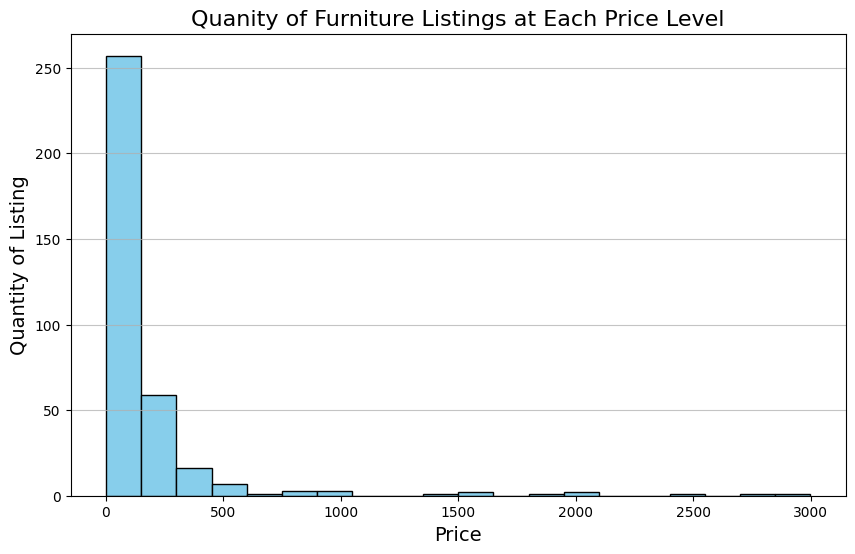

In [ ]:
#Price Histogram
plt.figure(figsize=(10,6))
plt.hist(df['price'], bins=20, color='skyblue', edgecolor='black')  # adjust bins as needed
plt.title('Quanity of Furniture Listings at Each Price Level', fontsize=16)
plt.xlabel('Price', fontsize=14)
plt.ylabel('Quantity of Listing', fontsize=14)
plt.grid(axis='y', alpha=0.75)
plt.show()

From the histogram above and the price description, we can see that the overwhelming majority of Craigslist furniture listings are under \$200. There are a few notable listings that are outliers, costing upwards of \$2,000.

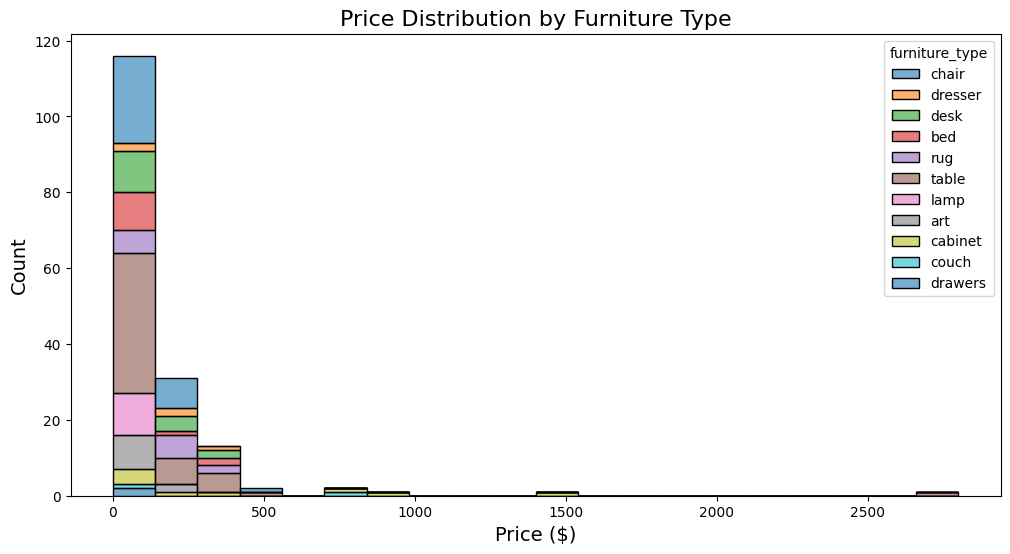

In [ ]:
#Price Histogram filtered by Furniture
plt.figure(figsize=(12,6))
sns.histplot(
    data=df[df["furniture_type"] != "missing"],  # optional: skip missing
    x="price",
    hue="furniture_type",
    bins=20,
    palette="tab10",
    alpha=0.6,
    multiple="stack"   # "dodge" for side-by-side
)
plt.title("Price Distribution by Furniture Type", fontsize=16)
plt.xlabel("Price ($)", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()


This histogram groups by furtniture type, giving us a better persepctive of what is in each bin. Many of these make sense (like all lamps being under \$200), though some seem to maintain relative ratios spanning multiple bins. For example, there are a fair amount of tables in each bin up to \$500.

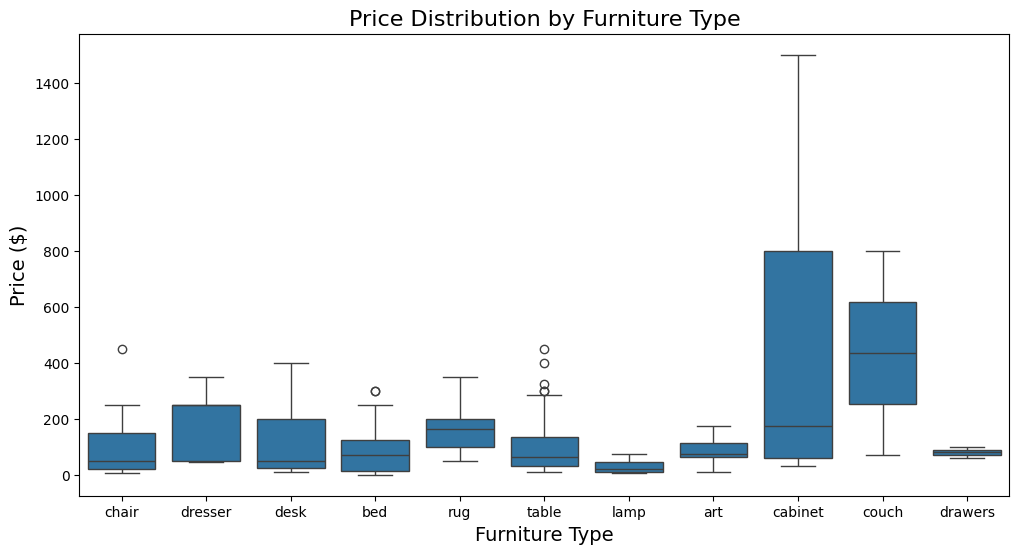

In [ ]:
# Furniture and Price Boxplot
plt.figure(figsize=(12,6))

sns.boxplot(
    data=df[(df["furniture_type"] != "missing") & (df["price"] <= 2500)], #gets rid of outlier that messes up plot
    x="furniture_type",
    y="price"
)

plt.title("Price Distribution by Furniture Type", fontsize=16)
plt.xlabel("Furniture Type", fontsize=14)
plt.ylabel("Price ($)", fontsize=14)


plt.show()

This box and whisker plot attempts to find trends across types of furniture. Some notable findings are the wide range of cabinet prices compared to all other furniture tyes. Additionally, couches have the highest avergae price by far, which makes sense as they tend to be an expensive piece of furniture.

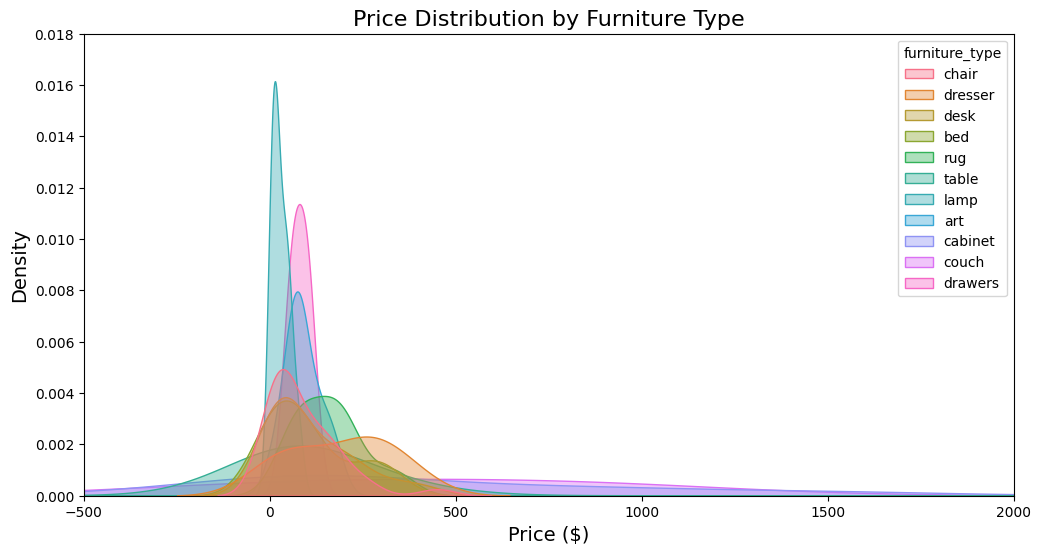

In [ ]:
# Furniture and Price Density Plot
plt.figure(figsize=(12,6))
sns.kdeplot(
    data=df[df["furniture_type"] != "missing"],
    x="price",
    hue="furniture_type",
    fill=True,
    alpha=0.4,
    common_norm=False
)
plt.title("Price Distribution by Furniture Type", fontsize=16)
plt.xlabel("Price ($)", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.xlim(-500, 2000)
plt.ylim(0, .018)
plt.show()

This Kernel Density plot shows a smoothed distribution of prices for each of the furniture sets. It demonstrates that some pieces are very similary (and usually low) priced, like lamps. Additionally, we see some pieces have much wider ranges, like couches. This makes sense as couches tend to range in price more and some are very expensive.

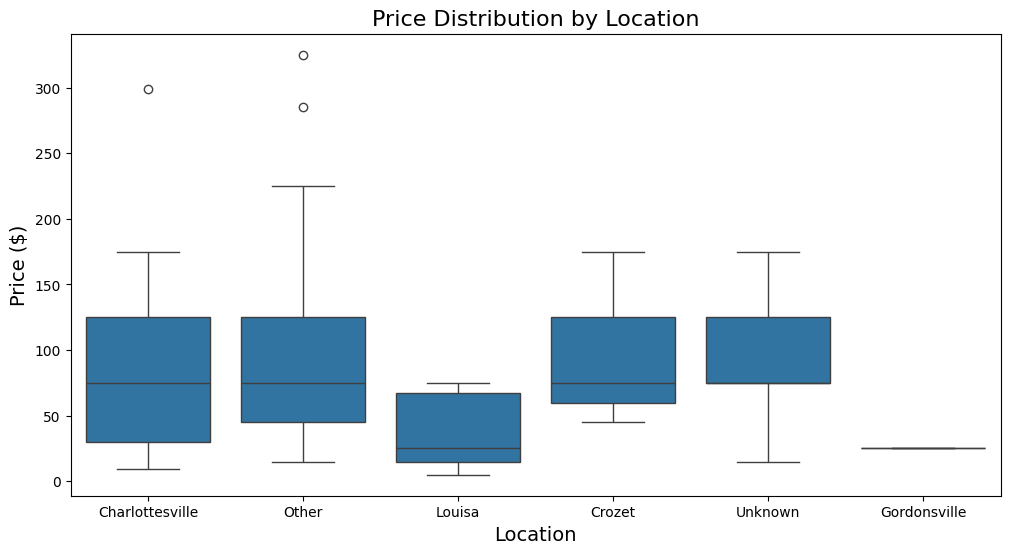

In [ ]:
# Location and Price Boxplot
plt.figure(figsize=(12,6))

sns.boxplot(
    data=df[(df["furniture_type"] != "missing") & (df["price"])],
    x="location",
    y="price"
)

plt.title("Price Distribution by Location", fontsize=16)
plt.xlabel("Location", fontsize=14)
plt.ylabel("Price ($)", fontsize=14)

plt.show()


This box and whisker plot attempts to find price trends across locations. One notable findings are the cheapest location seems to be Louisa, Virginia. Buyers looking for a baragin should consider checking listings out there.

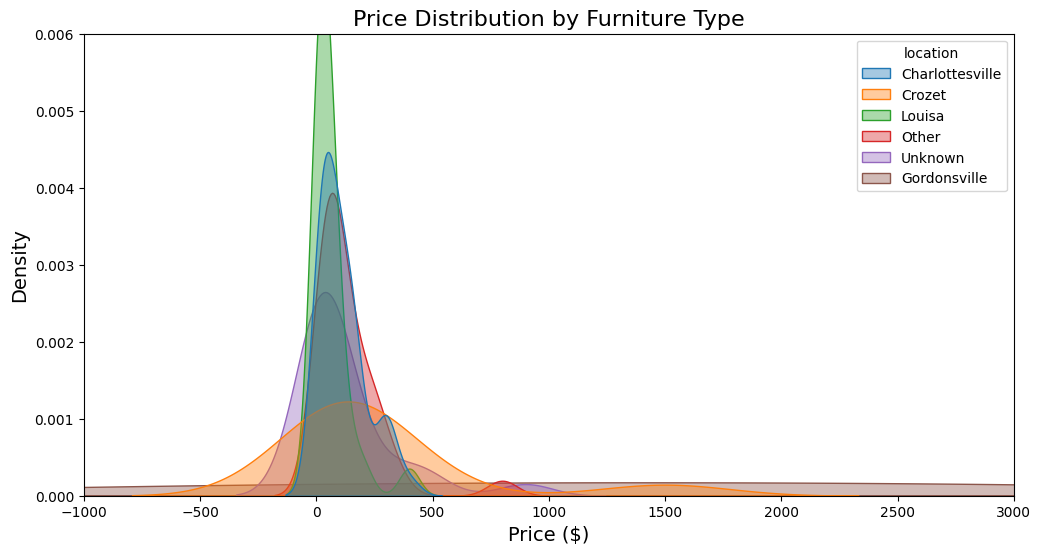

In [ ]:
# Location and Price Density Plot
plt.figure(figsize=(12,6))
sns.kdeplot(
    data=df[df["furniture_type"] != "missing"],
    x="price",
    hue="location",
    fill=True,
    alpha=0.4,
    common_norm=False
)
plt.title("Price Distribution by Location", fontsize=16)
plt.xlabel("Price ($)", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.xlim(-1000, 3000)
plt.ylim(0, .006)
plt.show()

This Kernel Density plot explores the distribution of prices among the location on the listing, to attempt to determine if a specific town around Charlottesville has more expensive pieces. There does not appear to be a clear trend, except Crozet seems to have a much wider range than other townships.